<a href="https://colab.research.google.com/github/besimorhino/ai-workshop/blob/main/space_approximates_meaning_vectors.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Space Approximates Meaning: A Tiny Vector Demo (Colab)

This lab demonstrates the idea that **nearby points in a vector space capture related meaning**.
We'll work with three animals:

- **Bearded dragon (lizard)**
- **American Longhair (cat)**
- **German shepherd (dog)**

We'll map each animal to a simple, human-designed vector with three dimensions:

1. **Furriness** (0–10 scale)  
2. **Weight** (kg)  
3. **Shoulder height** (m)  

> **Note:** Values here are *illustrative approximations* for the sake of learning—good enough to see geometry convey meaning. In a real ML system, vectors would be learned (e.g., via embeddings) rather than hand‑crafted.


In [ ]:

#@title Setup
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Display options
pd.set_option("display.precision", 3)
pd.set_option("display.max_colwidth", 100)

# Define our small "semantic" dataset
animals = [
    "Bearded dragon",
    "American Longhair (cat)",
    "German shepherd (dog)",
]

# Hand-crafted feature values (illustrative)
# Furriness: 0-10 (higher = furrier)
# Weight: kg (typical adult range midpoint-ish)
# Shoulder height: meters (approx. at the withers / comparable measure)
data = {
    "animal": animals,
    "furriness": [0.5, 9.0, 7.5],
    "weight_kg": [0.5, 4.5, 32.0],
    "shoulder_height_m": [0.10, 0.25, 0.63],
}

df = pd.DataFrame(data).set_index("animal")
df


,furriness,weight_kg,shoulder_height_m
animal,,,
Bearded dragon,0.5,0.5,0.10
American Longhair (cat),9.0,4.5,0.25
German shepherd (dog),7.5,32.0,0.63


## Visualizing one dimension at a time

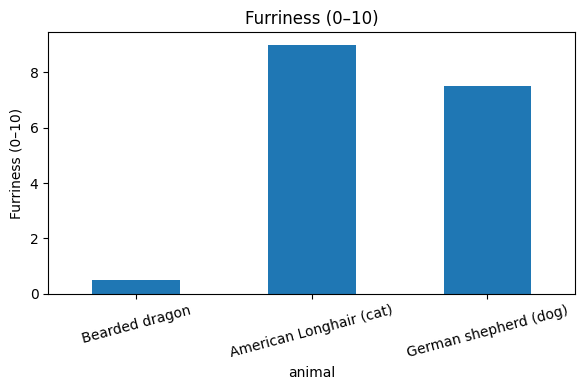

In [ ]:

# Furriness
ax = df["furriness"].plot(kind="bar", rot=15, figsize=(6,4), title="Furriness (0–10)")
ax.set_ylabel("Furriness (0–10)")
plt.tight_layout()
plt.show()


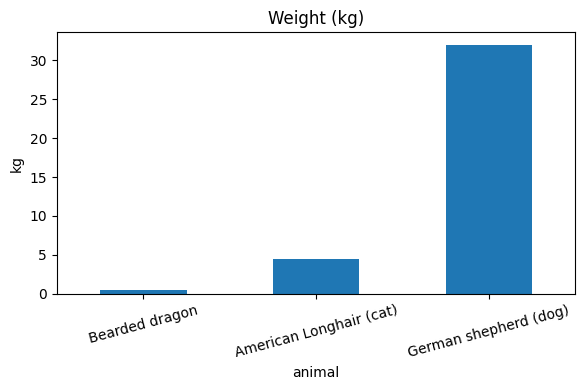

In [ ]:

# Weight
ax = df["weight_kg"].plot(kind="bar", rot=15, figsize=(6,4), title="Weight (kg)")
ax.set_ylabel("kg")
plt.tight_layout()
plt.show()


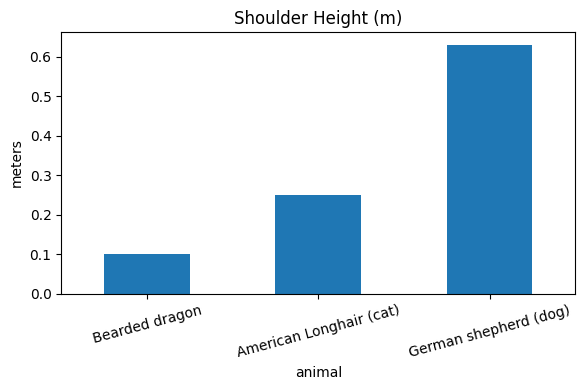

In [ ]:

# Shoulder height
ax = df["shoulder_height_m"].plot(kind="bar", rot=15, figsize=(6,4), title="Shoulder Height (m)")
ax.set_ylabel("meters")
plt.tight_layout()
plt.show()



## From features to vectors

Combine the three features into a 3D vector for each animal. We'll also create a **normalized** version where each feature is scaled to `[0, 1]`, ensuring no single unit dominates distance just because of its raw scale (e.g., kilograms vs meters).


In [ ]:

# Assemble raw vectors
X_raw = df[["furriness", "weight_kg", "shoulder_height_m"]].values

# Min-max normalize each column to [0, 1]
mins = X_raw.min(axis=0)
maxs = X_raw.max(axis=0)
ranges = np.where((maxs - mins) == 0, 1.0, (maxs - mins))
X_norm = (X_raw - mins) / ranges

# Put both into DataFrames for clarity
raw_cols = ["furriness", "weight_kg", "shoulder_height_m"]
df_vectors_raw = pd.DataFrame(X_raw, index=df.index, columns=raw_cols)
df_vectors_norm = pd.DataFrame(X_norm, index=df.index, columns=[c + "_norm" for c in raw_cols])

display(df_vectors_raw)
display(df_vectors_norm)


,furriness,weight_kg,shoulder_height_m
animal,,,
Bearded dragon,0.5,0.5,0.10
American Longhair (cat),9.0,4.5,0.25
German shepherd (dog),7.5,32.0,0.63


,furriness_norm,weight_kg_norm,shoulder_height_m_norm
animal,,,
Bearded dragon,0.000,0.000,0.000
American Longhair (cat),1.000,0.127,0.283
German shepherd (dog),0.824,1.000,1.000



## Plot the 3D vector space (normalized)

Points that are **closer** represent animals that are **more similar** under our chosen features.


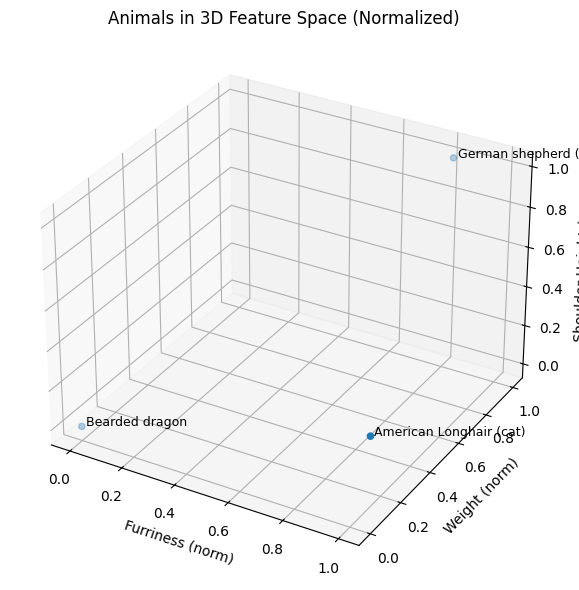

In [ ]:

from mpl_toolkits.mplot3d import Axes3D  # noqa: F401

fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111, projection='3d')

xs = df_vectors_norm["furriness_norm"].values
ys = df_vectors_norm["weight_kg_norm"].values
zs = df_vectors_norm["shoulder_height_m_norm"].values

ax.scatter(xs, ys, zs)

for i, name in enumerate(df_vectors_norm.index):
    ax.text(xs[i], ys[i], zs[i], " " + name, fontsize=9)

ax.set_xlabel("Furriness (norm)")
ax.set_ylabel("Weight (norm)")
ax.set_zlabel("Shoulder Height (norm)")
ax.set_title("Animals in 3D Feature Space (Normalized)")
plt.tight_layout()
plt.show()



## Distances & Similarities

We'll compute both **Euclidean distance** and **cosine similarity** between every pair.
- **Euclidean distance:** how far apart points are in the space.
- **Cosine similarity:** how aligned the vectors are (angle-based).

On this toy dataset, we should see that the **cat** and **dog** end up closer/more similar to each other than to the **lizard**, reflecting intuitive meaning.


In [ ]:

def euclidean_distance_matrix(X):
    # X: (n, d)
    diffs = X[:, None, :] - X[None, :, :]
    dists = np.sqrt((diffs ** 2).sum(axis=-1))
    return dists

def cosine_similarity_matrix(X):
    # X: (n, d)
    norms = np.linalg.norm(X, axis=1, keepdims=True)
    Xn = np.divide(X, np.where(norms==0, 1.0, norms))
    return Xn @ Xn.T

E = euclidean_distance_matrix(X_norm)
C = cosine_similarity_matrix(X_norm)

df_euclid = pd.DataFrame(E, index=df.index, columns=df.index)
df_cosine = pd.DataFrame(C, index=df.index, columns=df.index)

display(df_euclid.round(3))
display(df_cosine.round(3))


animal,Bearded dragon,American Longhair (cat),German shepherd (dog)
animal,,,
Bearded dragon,0.000,1.047,1.637
American Longhair (cat),1.047,0.000,1.143
German shepherd (dog),1.637,1.143,0.000


animal,Bearded dragon,American Longhair (cat),German shepherd (dog)
animal,,,
Bearded dragon,0.0,0.00,0.00
American Longhair (cat),0.0,1.00,0.72
German shepherd (dog),0.0,0.72,1.00



### Heatmap views


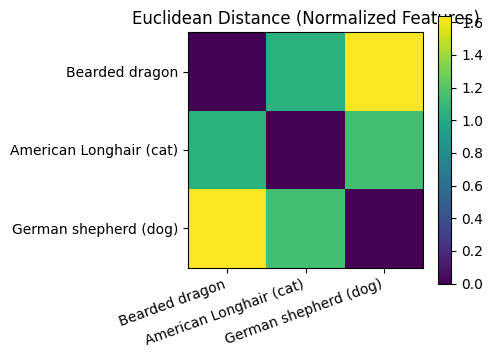

In [ ]:

# Euclidean distance heatmap
fig = plt.figure(figsize=(5,4))
plt.imshow(df_euclid.values, interpolation='nearest')
plt.title("Euclidean Distance (Normalized Features)")
plt.xticks(range(len(df_euclid.columns)), df_euclid.columns, rotation=20, ha='right')
plt.yticks(range(len(df_euclid.index)), df_euclid.index)
plt.colorbar()
plt.tight_layout()
plt.show()


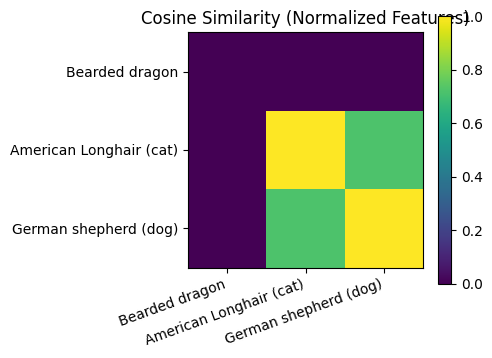

In [ ]:

# Cosine similarity heatmap
fig = plt.figure(figsize=(5,4))
plt.imshow(df_cosine.values, interpolation='nearest')
plt.title("Cosine Similarity (Normalized Features)")
plt.xticks(range(len(df_cosine.columns)), df_cosine.columns, rotation=20, ha='right')
plt.yticks(range(len(df_cosine.index)), df_cosine.index)
plt.colorbar()
plt.tight_layout()
plt.show()



## Nearest neighbors (who's closest to whom?)

Using cosine similarity and Euclidean distance, identify each animal's closest neighbor.


In [ ]:

def nearest_neighbor_by_distance(df_dist):
    out = {}
    for row in df_dist.index:
        # exclude self (distance 0)
        neighbors = df_dist.loc[row].drop(labels=[row])
        out[row] = neighbors.idxmin()
    return out

def nearest_neighbor_by_cosine(df_cos):
    out = {}
    for row in df_cos.index:
        # exclude self (similarity 1)
        neighbors = df_cos.loc[row].drop(labels=[row])
        out[row] = neighbors.idxmax()
    return out

nn_euclid = nearest_neighbor_by_distance(df_euclid)
nn_cosine = nearest_neighbor_by_cosine(df_cosine)

print("Nearest neighbor by Euclidean distance:")
for k, v in nn_euclid.items():
    print(f"  {k} → {v}")

print("\nNearest neighbor by Cosine similarity:")
for k, v in nn_cosine.items():
    print(f"  {k} → {v}")


Nearest neighbor by Euclidean distance:
  Bearded dragon → American Longhair (cat)
  American Longhair (cat) → Bearded dragon
  German shepherd (dog) → American Longhair (cat)

Nearest neighbor by Cosine similarity:
  Bearded dragon → American Longhair (cat)
  American Longhair (cat) → German shepherd (dog)
  German shepherd (dog) → American Longhair (cat)



## Wrap‑up

- We picked **three human-interpretable features** and placed each animal as a point in this 3D space.
- **Proximity** (small distances / high cosine similarity) corresponds to **perceived relatedness** under those features.
- This mirrors how embedding spaces in modern ML work: **nearby vectors share meaning**, even when the model builds those vectors from complex data instead of simple hand-crafted features.

Try modifying feature weights, adding new dimensions (e.g., *diet type*, *nocturnal vs diurnal*, *lifespan*), or introducing more animals to see how the geometry—and therefore the **meaning**—shifts.
